# 1. Preamble

## Yelp Dataset Challenge 


Yelp challenges students to use their data in innovative ways and break ground in research. There is a myriad of deep, machine learning questions to tackle with this rich dataset:

- How well can you guess a review's rating from its text alone? 
- Can you take all of the reviews of a business and predict when it will be the most busy, or when the business is open? 
- Can you predict if a business is good for kids? Has WiFi? Has Parking? 
- What makes a review useful, funny, or cool? 
- Can you figure out which business a user is likely to review next? 
- How much of a business's success is really just location, location, location? 
- What businesses deserve their own subcategory (i.e., Szechuan or Hunan versus just “Chinese restaurants”), and can you learn this from the review text?
- What are the differences between the cities in the dataset?

See some of the [past winners](https://www.yelp.com/dataset/challenge/winners) and hundreds of [academic papers](https://scholar.google.com/scholar?q=citation%3A+Yelp+Dataset&btnG=&hl=en&as_sdt=0%2C5) written using the dataset.

# 2. Yelp Dataset JSON

Download the data: https://www.yelp.com/dataset/download. 

Each file is composed of a single object type, one JSON-object per-line.

- `business.json`: contains business data including location data, attributes, and categories.
- `review.json`: Contains full review text data including the `user_id` that wrote the review and the `business_id` the review is written for.
- `user.json`: User data including the user's friend mapping and all the metadata associated with the user.
- `checkin.json`: Checkins on a business.
- `tip.json`: Tips written by a user on a business. Tips are shorter than reviews and tend to convey quick suggestions.
- `photos` (from the photos auxiliary file): This file is formatted as a JSON list of objects.


Take a look at some examples to get you started: https://github.com/Yelp/dataset-examples.

# 3. Data loading

We will focus on analyzing user review text included in the file `review.json`. 

We moreover use business information to determine how the user review text is related to business specific atributes such as ambiance, category, location, etc. 

## Business data
Road map:

(i) We first notice that one of the entries of the JSON object in `business.json` is`review_count` which gives the number of reviews for any given business. What we want to do is to start by filtering out all businesses with at least a minimum number of reviews to conduct our analysis. In this case we choose businesses with at least **500 reviews**.

(ii) Other relevant information that we want to include are:
- `business_id`
- `state`
- `city`
- `categories`
- `attributes`
    
The main challenge in order to conduct (i) and (ii) above is that business information comes in a JSON file consisting of a JSON object for each line, aka [JSON Lines](http://jsonlines.org/). A viable option is for example to read the file into python, convert it into a pandas DataFrame, selecting the fiels  of interest and filter out those records whose number of reviews in greater than 500. 


## `jq`

Since we would like to avoid reading large files into memory, we instead take avantage of the fact that business information consists of several JSON objects and will perform the latter using command line tools, namely [jq](https://stedolan.github.io/jq/), which is *a language is based on the same concepts of streams, pipes, and filters that are familiar from the Unix shell*. You can find some `jq` basic examples [here](https://robots.thoughtbot.com/jq-is-sed-for-json). Another very useful resource to text `jq` commands on-line: https://jqplay.org/.

The `jq` line below executes the following: 

1. [Selects a subset of keys from an object
](https://stackoverflow.com/questions/29518137/jq-selecting-a-subset-of-keys-from-an-object?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa) using `with_entries()`. 

2. [Filters out the JSON lines according to a specific criteria](http://bigdatums.net/2016/11/16/filter-json-records-by-value-with-jq/) using `select()`.

Notice that in analogy to other bash commands, we can use the pipe operator `|` to use the output of one commandas and the input of the subsequent one. Futheremore, by using `jq --compact-output` (or `-c`) we can get each object on a newline. The output is also re-directed  into `train_business.json` by using `>`.

We start downloading `business.json` (not from the original Yelp website but from my UCSB Google Drive).

We note that is *not recommended* to check-in [extremely large files on Github](https://help.github.com/articles/working-with-large-files/).

Instead, what we do is to save it into Google drive and then `wget` from the shared link. The latter process is done using the bash [script below](https://gist.github.com/iamtekeste/3cdfd0366ebfd2c0d805#gistcomment-2359248):

In [ ]:
%%bash
function gdrive_download () {
  CONFIRM=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate "https://drive.google.com/uc?export=download&id=$1" -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')
  wget --load-cookies /tmp/cookies.txt "https://drive.google.com/uc?export=download&confirm=$CONFIRM&id=$1" -O $2
  rm -rf /tmp/cookies.txt
}
# Fist argument is the file id (which we get from right-clicking the file in Google drive and
# copying the last string appearing after id=)
gdrive_download 1nmPJorJ4uGoHInq_1lz1ePElvtVjbA3l business.json

In [ ]:
# not run
! jq -c 'with_entries(select([.key] \
            | inside(["business_id","state","city","categories","attributes","review_count"]))) \
            | select(.review_count>500)' business.json > train_business.json

In [ ]:
# not run
! wc -l train_business.json # Number of businesses with at least 500 reviews (923)

We now read `train_business.json` [into python](https://stackoverflow.com/questions/46790390/how-to-read-a-large-json-in-pandas), keeping in mind that the latter is a JSON Lines object:

In [36]:
import pandas as pd
import json

with open('train_business.json') as json_file:      
    data_business = json_file.readlines()
    data_business = list(map(json.loads, data_business)) 

For our training data we will consider only 100 randomly chosen businesses from the subset of businesses with at least 500 reviews:

In [37]:
import numpy as np

In [38]:
train_business = [data_business[index] for index \
                  in np.random.randint(0,len(data_business),size=100)]

## Review data

The next step is to obtain the actual reviews corresponding to the 100 randomly chosen businesses with at least 500 reviews. 

After trying doing so using `jq` (which would require to filter according to a list of `business_id`), I found that the most efficient way to do so is to read `review.json` (which contains ~5M JSON Lines) into python and then perform list comprehension to select the reviews for the businesses in question. The resulting *list* (named `train_review`) is serialized as a pkl object.

The above procedure is included in `read_reviews.py`.



# 4. Text Mining on Yelp Dataset

In [23]:
%%bash
function gdrive_download () {
  CONFIRM=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate "https://drive.google.com/uc?export=download&id=$1" -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')
  wget --load-cookies /tmp/cookies.txt "https://drive.google.com/uc?export=download&confirm=$CONFIRM&id=$1" -O $2
  rm -rf /tmp/cookies.txt
}

gdrive_download 1fHyBolkVadlT3QB6C7pu9-qVrsWde7Tg train_review.pkl

--2018-05-24 21:09:54--  https://drive.google.com/uc?export=download&confirm=g64j&id=1riaZl6ukFOiyOGxnFqkYgUrPSuwXGAYL
Resolving drive.google.com (drive.google.com)... 172.217.4.142, 2607:f8b0:4007:804::200e
Connecting to drive.google.com (drive.google.com)|172.217.4.142|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-08-b0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/7jmt3gfvfu3gau0dkuqg7punm556gesg/1527192000000/18325861008336288019/*/1riaZl6ukFOiyOGxnFqkYgUrPSuwXGAYL?e=download [following]
--2018-05-24 21:09:54--  https://doc-08-b0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/7jmt3gfvfu3gau0dkuqg7punm556gesg/1527192000000/18325861008336288019/*/1riaZl6ukFOiyOGxnFqkYgUrPSuwXGAYL?e=download
Resolving doc-08-b0-docs.googleusercontent.com (doc-08-b0-docs.googleusercontent.com)... 172.217.4.129, 2607:f8b0:4007:800::2001
Connecting to doc-08-b0-docs.googleusercontent.com (doc-0

In [19]:
import  pickle
train_review = pickle.load(open('train_review.pkl', "rb" ))

In [20]:
type(train_review)

list

In [21]:
train_review[1]

{'review_id': 'Qbw9bPauIVHfrWUlHNDLTA',
 'user_id': 'YshEkGvjWClHLCuC3W_d9A',
 'business_id': 'eAc9Vd6loOgRQolMXQt6FA',
 'stars': 4,
 'date': '2011-04-13',
 'text': 'Our friend TSmith loves this place due to the cocunut smell they pump through the air vents. We stayed here for the second time at the top of this month and still enjoyed it. \n\nVery clean, beautiful hotel casino. The Hotel has suites that we stayed in over the summer but even the regular Mandalay rooms are great.\n\nOn the pricey side for the strip but at least worth a stay once if you do Vegas.',
 'useful': 0,
 'funny': 0,
 'cool': 0}

- The main resource that we will use for performing text mining on Yelp reviews text will be [Text Analytics with Python](https://github.com/dipanjanS/text-analytics-with-python).

- We will start by downloading the auxiliary functions  which are part of the textbook repo.

In [ ]:
! wget https://raw.githubusercontent.com/dipanjanS/text-analytics-with-python/master/Chapter-4/feature_extractors.py

In [2]:
# Extract text
review_corpus = [text['text'] for text in train_review]

In [3]:
# example (10 reviews)
text = review_corpus[:10].copy()

In [66]:
text[0]

'This place absolutely amazing I really enjoyed atmosphere food This place want try new My friends I ordered horse accident tried anyways really bad The waiters really nice place loud really energetic Would definitely'

The following are some of the main steps outline a typical workflow for for text mining, assuming we have our dataset already downloaded and ready to be used:

1. Text normalization
2. Feature extraction

# Text Normalization

Text normalization is defined as a process that consists of a series of steps that should be followed to wrangle, clean, and standardize textual data into a form that could be consumed by other NLP and analytics systems and applications as input. 

Often tokenization itself also is a part of text normalization. 

Besides tokenization, various other techniques include:

1. Removing special characters (text cleaning)
2. Case conversion
3. Correcting spellings
4. Removing stopwords and other unnecessary terms
5. Lemmatization

Text normalization is also often called *text cleansing or wrangling*.

In [ ]:
! pip install nltk

In [5]:
# download dictionaty of stop words
import nltk
nltk.download('stopwords')
nltk.download('punkt') # tockenizer

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
# import necessary modules
import re
import nltk
import string
from nltk.stem import WordNetLemmatizer

wnl = WordNetLemmatizer()

##  Tokenizing Text


Sentence tokenization is the process of splitting a text corpus into sentences that act as the first level of tokens which the corpus is comprised of. This is also known as sentence segmentation, because we try to segment the text into meaningful sentences. Any text corpus is a body of text where each paragraph comprises several sentences.

We will use the `nltk` framework, which provides various interfaces for performing sentence tokenization. 

In [7]:
def tokenize_text(text):
    tokens = nltk.word_tokenize(text) 
    tokens = [token.strip() for token in tokens]
    return tokens

## Expand contractions

Contractions are shortened version of words or syllables. They exist in either written or spoken forms. Shortened versions of existing words are created by removing specific letters and sounds. In case of English contractions, they are often created by removing one of the vowels from the word. 

A vocabulary for contractions and their corresponding expanded forms that you can access in the file `contractions2.py` in a Python dictionary (which we again download from the textbook repo).



In [8]:
def expand_contractions(text, contraction_mapping):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

In [9]:
from contractions2 import CONTRACTION_MAP

In [67]:
text = [expand_contractions(sentence, CONTRACTION_MAP) for sentence in text]

In [68]:
text[0]

'This place absolutely amazing I really enjoyed atmosphere food This place want try new My friends I ordered horse accident tried anyways really bad The waiters really nice place loud really energetic Would definitely'

## Removing Special Characters

One important task in text normalization involves removing unnecessary and special characters. These may be special symbols or even punctuation that occurs in sentences. This step is often performed before or after tokenization. The main reason for doing so is because often punctuation or special characters do not have much significance when we analyze the text and utilize it for extracting features or information based on NLP and ML.

In [12]:
def remove_special_characters(text):
    tokens = tokenize_text(text)
    pattern = re.compile('[{}]'.format(re.escape(string.punctuation)))
    filtered_tokens = filter(None, [pattern.sub('', token) for token in tokens])
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

In [69]:
text = [remove_special_characters(sentence) for sentence in text]

In [70]:
text[0]

'This place absolutely amazing I really enjoyed atmosphere food This place want try new My friends I ordered horse accident tried anyways really bad The waiters really nice place loud really energetic Would definitely'

## Removing Stopwords
Stopwords are words that have little or no significance. They are usually removed from text during processing so as to retain words having maximum significance and context. Stopwords are usually words that end up occurring the most if you aggregated any corpus of text based on singular tokens and checked their frequencies.

In [15]:
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

In [16]:
def remove_stopwords(text,stopword_list):
    tokens = tokenize_text(text)
    filtered_tokens = [token for token in tokens if token not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

In [17]:
text = [remove_stopwords(sentence,
                         stopword_list=list(ENGLISH_STOP_WORDS))\
        for sentence in text]

## Identifying Parts of Speech and Lemmatization

Now that we have a function for expanding contractions, we implement a function for standardizing our text data by bringing word tokens to their base or root form using lemmatization. The following functions will help us in achieving that:

In [ ]:
nltk.download(['averaged_perceptron_tagger',
               'universal_tagset',
               'wordnet'])

In [92]:
# example
sentence = 'The brown fox is quick and he is jumping over the lazy dog jumps'
tokens = nltk.word_tokenize(sentence)
tagged_sent = nltk.pos_tag(tokens, tagset='universal')

In [93]:
tagged_sent

[('The', 'DET'),
 ('brown', 'ADJ'),
 ('fox', 'NOUN'),
 ('is', 'VERB'),
 ('quick', 'ADJ'),
 ('and', 'CONJ'),
 ('he', 'PRON'),
 ('is', 'VERB'),
 ('jumping', 'VERB'),
 ('over', 'ADP'),
 ('the', 'DET'),
 ('lazy', 'ADJ'),
 ('dog', 'NOUN'),
 ('jumps', 'NOUN')]

In [18]:
from nltk import pos_tag
from nltk.corpus import wordnet as wn

# Annotate text tokens with POS tags
def pos_tag_text(text):
    
    def penn_to_wn_tags(pos_tag):
        if pos_tag.startswith('J'):
            return wn.ADJ
        elif pos_tag.startswith('V'):
            return wn.VERB
        elif pos_tag.startswith('N'):
            return wn.NOUN
        elif pos_tag.startswith('R'):
            return wn.ADV
        else:
            return None

    tagged_text = pos_tag(text)
    tagged_lower_text = [(word.lower(), penn_to_wn_tags(pos_tag))
                         for word, pos_tag in
                         tagged_text]
    return tagged_lower_text

## Lemmatization
- The process of lemmatization is very similar to stemming; you remove word affixes to get to a base form of the word. 

- But in this case, this base form is also known as the root word, but not the root stem. 

- The difference is that the root stem may not always be a lexicographically correct word; that is, it may not be present in the dictionary. The root word, also known as the lemma, will always be present in the dictionary.

In [19]:
# lemmatize text based on POS tags    
def lemmatize_text(text):
    text = tokenize_text(text)
    pos_tagged_text = pos_tag_text(text)
    lemmatized_tokens = [wnl.lemmatize(word, pos_tag) if pos_tag
                         else word                     
                         for word, pos_tag in pos_tagged_text]
    lemmatized_text = ' '.join(lemmatized_tokens)
    return lemmatized_text

In [94]:
tokens = [tokenize_text(sentence) for sentence in text] 

In [95]:
text = [tokenize_text(tokens) for tokens in text] 

In [20]:
# Text normalization pipeline
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
import re

def keep_text_characters(text):
    filtered_tokens = []
    tokens = tokenize_text(text)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

def normalize_text(text,tokenize=False):
    text = expand_contractions(text, CONTRACTION_MAP)
    text = lemmatize_text(text)
    text = remove_special_characters(text)
    text = text.lower()
    text = remove_stopwords(text,ENGLISH_STOP_WORDS)
    text = keep_text_characters(text)

    return text

In [71]:
review_corpus[0]

"This place was absolutely amazing, I really enjoyed the atmosphere and the food. This is the place if you want to try something new. My friends and I ordered horse on accident but we tried it anyways, it really wasn't that bad. The waiters a really nice and the place is loud but really energetic. Would definitely go again."

In [72]:
normalize_text(review_corpus[0])

'place absolutely amazing really enjoy atmosphere food place want try new friend order horse accident try anyways really bad waiter really nice place loud really energetic definitely'

In [23]:
len(review_corpus)

83190

In [24]:
import timeit
start_time = timeit.default_timer()
review_corpus_norm = [normalize_text(text) for text in review_corpus]
elapsed = timeit.default_timer() - start_time

## (Embarrassingly) parallel processing

In order to normalize all 83,190 reviews corresponding to our randomly selected 100 businesses we accelerate text normalization by executing them in [parallel](https://hpc-carpentry.github.io/hpc-python/06-parallel/).

In [ ]:
!pip install --user multiprocess

In [ ]:
# not run
from multiprocess import Pool
start_time = timeit.default_timer()

# start your parallel workers at the beginning of your script
pool = Pool(2) # Number of cores

# execute a computation(s) in parallel
review_corpus_norm = pool.map(normalize_text,CORPUS)

# turn off your parallel workers at the end of your script
pool.close()

elapsed = timeit.default_timer() - start_time

In [ ]:
elapsed

In [26]:
review_corpus_norm[1]

'friend tsmith love place cocunut smell pump air vent stay second time month enjoy clean beautiful hotel casino hotel suite stay summer regular mandalay room great pricey strip worth stay vega'

In [73]:
pickle.dump(review_corpus_norm,open('review_corpus_norm.pkl','wb'))

# Feature Extraction

- In ML terminology, features are unique, measurable attributes or properties for each observation or data point in a dataset. Features are usually numeric in nature and can be absolute numeric values or categorical.
- With textual data there is the added challenge of figuring out how to transform textual data and extract numeric features from it.

## Vector Space Model

Say we have a document $D$ in a document vector space VS. The number of dimensions or columns for each document will be the total number of distinct terms or words for all documents in the vector space. So, the vector space can be denoted
$$
VS:=\{W_{1},\ldots,W_{n}\}
$$
where there are $n$ distinct words across all documents. Now we can represent document $D$ in this vector space as
$$
D:=\{w_{D1},w_{D2},\ldots,W_{Dn}\},
$$
where $W_{Dn}$ denotes the weight for word $n$ in document $D$. 

Examples of feature-extraction techniques are:
1. Bag of Words model
2. TF-IDF model

We will use of the `nltk`, `gensim`, and `scikit-learn` libraries,

### Bag of Words model

Each document is converted into a vector that represents the frequency of all the distinct words that are present in the document vector space for that specific document.

### TF-IDF Model

The Bag of Words model is good, but the vectors are completely based on absolute frequencies of word occurrences. This has some potential problems where words that may tend to occur a lot across all documents in the corpus will have higher frequencies and will tend to overshadow other words that may not occur as frequently but may be more interesting and effective as features to identify specific categories for the documents. 

TF-IDF stands for *Term Frequency-Inverse Document Frequency*, a combination of two metrics:

(i) Term frequency, $tf$, is what we had computed in the Bag of Words model (i.e., raw frequency value of that term in a particular document).

(ii) Inverse document frequency, $idf$, is the inverse of the document frequency for each term. It is computed by dividing the total number of documents in our corpus by the document frequency for each term and then applying logarithmic scaling on the result.
$$
idf_{ij}=1+\log \frac{C}{1+df_{i}}
$$
where $idf_{ij}$ represents the $idf$ for the $j$-th term in document $i$, $C$ represents the count of the total number of documents in our corpus, and $df_{i}$ represents the frequency of the number of documents in which the term $i$ is present.

- The final TF-IDF metric we will be using is a normalized version of the tfidf matrix we get from the product of 
$$
T_{ij}:=tf_{ij}\times idf_{ij}.
$$

- Typically, the TF-IDF matrix, 
$$
T:=\{T_{1},\ldots,T_{n}\}
$$
is normalized by dividing each $T_{i}$ with respect to the $L_2$ norm of the matrix (defined as the square root of the sum of the square of each $T_{i}$). The final $tfidf$ feature vector is given by:
$$
T_{i}:= \frac{T_{i}}{||T_{i}||_{2}^{2}}, i=1,\ldots,n.
$$
where $||T_{i}||_{2}^{2}$ represents the Euclidean norm for the TF-IDF matrix.



In [24]:
%%bash
function gdrive_download () {
  CONFIRM=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate "https://drive.google.com/uc?export=download&id=$1" -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')
  wget --load-cookies /tmp/cookies.txt "https://drive.google.com/uc?export=download&confirm=$CONFIRM&id=$1" -O $2
  rm -rf /tmp/cookies.txt
}

gdrive_download 1GGc42WEuqiiGtE8Hg6KTxO8QTBQqHNtS review_corpus_norm.pkl

--2018-05-24 21:14:49--  https://drive.google.com/uc?export=download&confirm=&id=1QYV8nG09UCO9FpyQwUZvTTy7WOS33edC
Resolving drive.google.com (drive.google.com)... 172.217.11.174, 2607:f8b0:4007:804::200e
Connecting to drive.google.com (drive.google.com)|172.217.11.174|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-b0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/o1g7kcshucbrjhtognpfdrsbujds4egu/1527192000000/18325861008336288019/*/1QYV8nG09UCO9FpyQwUZvTTy7WOS33edC?e=download [following]
--2018-05-24 21:14:49--  https://doc-0s-b0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/o1g7kcshucbrjhtognpfdrsbujds4egu/1527192000000/18325861008336288019/*/1QYV8nG09UCO9FpyQwUZvTTy7WOS33edC?e=download
Resolving doc-0s-b0-docs.googleusercontent.com (doc-0s-b0-docs.googleusercontent.com)... 172.217.4.129, 2607:f8b0:4007:804::2001
Connecting to doc-0s-b0-docs.googleusercontent.com (doc-0s-

In [32]:
import  pickle
review_corpus_norm = pickle.load(open('review_corpus_norm.pkl', "rb" ))

In [44]:
# TF-IDF 
import numpy as np
from feature_extractors import tfidf_transformer
from feature_extractors import bow_extractor    

def tf_idf(corpus):
    # Bag of words construction
    bow_vectorizer, bow_features = bow_extractor(corpus=corpus)
    # feature names
    feature_names = bow_vectorizer.get_feature_names()
    # TF-IDF    
    tfidf_trans, tdidf_features = tfidf_transformer(bow_features)
    tdidf_features = np.round(tdidf_features.todense(),2)
    return((tdidf_features, feature_names))


In [ ]:
tdidf_features,feature_names = tf_idf(review_corpus_norm) # memory error

Since there is not enought memory to process all selected review, let's restrict our attention to business from *California*:

In [34]:
def check_state(business,state = "CA"):
    flag = any([category in state for category in business['state']])
    return(flag)

In [39]:
# get business_id from 
business_id_ca = [business['business_id'] for business in train_business \
       if check_state(business,"CA")]

In [40]:
reviews_ca = [review['business_id'] in business_id_ca \
              for review in train_review] 

In [41]:
review_corpus_norm_ca = [review for (review,cond) in \
                         zip(review_corpus_norm,reviews_ca) if cond] 

In [42]:
print("No.reviews in CA:",len(review_corpus_norm_ca),"\n"
      "No.reviews in total:",len(review_corpus_norm))

No.reviews in CA: 1575 
No.reviews in total: 83190


In [45]:
tdidf_features,feature_names = tf_idf(review_corpus_norm_ca) 

# Topic Modeling

*Topic models* have been designed specifically for the purpose of extracting various distinguishing concepts or topics from a large corpus containing various types of documents.

Topic modeling is a *unsupervised* learning technique since involves extracting features from document terms to generate clusters or groups of terms that are distinguishable from each other, and these cluster of words form topics or concepts. 

Some methods for topic discovery include:
- Latent semantic indexing
- Latent Dirichlet allocation
- Non-negative matrix factorization



## Non-negative Matrix Factorization

In [46]:
X = tdidf_features.T

In [47]:
X.shape # 10 documents, 363 unique words

(6132, 1575)

In [48]:
## Non-negative Matrix Factorization
def non_negative_marix_decomp(n_components,train_data):
    import sklearn.decomposition as skld
    model = skld.NMF(n_components=n_components, 
                     init='nndsvda', max_iter=500, 
                     random_state=0)
    W = model.fit_transform(train_data)
    H = model.components_
    nmf = (W,H)
    return(nmf)

In [49]:
# page 246
r = 10 # no. of topics
W_topic,H_topic = non_negative_marix_decomp(n_components = r,
                                            train_data = X) 

In [ ]:
! wget https://raw.githubusercontent.com/dipanjanS/text-analytics-with-python/master/Chapter-5/topic_modeling.py

In [50]:
H_topic /= H_topic.sum(0)

# Topic Visualization

In [ ]:
# https://de.dariah.eu/tatom/topic_model_visualization.html

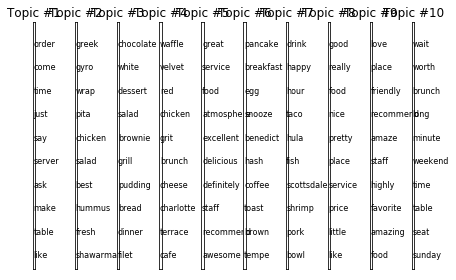

In [60]:
import matplotlib.pyplot as plt

num_top_words = 10
num_topics = 10
word_topic = W_topic
fontsize_base = 8# / np.max(word_topic) # font size for word with largest share in corpus

for t in range(num_topics):
    plt.subplot(1, num_topics, t + 1)  # plot numbering starts with 1
    plt.ylim(0, num_top_words + 0.5)  # stretch the y-axis to accommodate the words
    plt.xticks([])  # remove x-axis markings ('ticks')
    plt.yticks([]) # remove y-axis markings ('ticks')
    plt.title('Topic #{}'.format(t+1))
    top_words_idx = np.argsort(word_topic[:,t])[::-1]  # descending order
    top_words_idx = top_words_idx[:num_top_words]
    top_words = [feature_names[k] for k in top_words_idx]
    top_words_shares = word_topic[top_words_idx, t]
    for i, (word, share) in enumerate(zip(top_words, top_words_shares)):
        plt.text(0.3, 
                 num_top_words-i-0.5, 
                 word, 
                 fontsize=fontsize_base)
                 #fontsize=fontsize_base*share)
        
plt.tight_layout()

In [65]:
# page 246
r = 5 # no. of topics
W_topic,H_topic = non_negative_marix_decomp(n_components = r,
                                            train_data = X) 

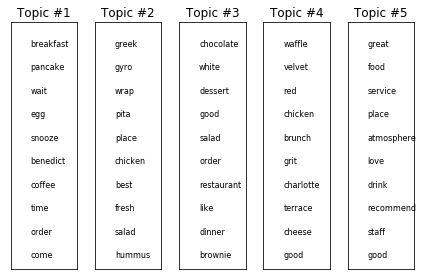

In [75]:
import matplotlib.pyplot as plt

num_top_words = 10
num_topics = 5
word_topic = W_topic
fontsize_base = 8# / np.max(word_topic) # font size for word with largest share in corpus

for t in range(num_topics):
    plt.subplot(1, num_topics, t + 1)  # plot numbering starts with 1
    plt.ylim(0, num_top_words + 0.5)  # stretch the y-axis to accommodate the words
    plt.xticks([])  # remove x-axis markings ('ticks')
    plt.yticks([]) # remove y-axis markings ('ticks')
    plt.title('Topic #{}'.format(t+1))
    top_words_idx = np.argsort(word_topic[:,t])[::-1]  # descending order
    top_words_idx = top_words_idx[:num_top_words]
    top_words = [feature_names[k] for k in top_words_idx]
    top_words_shares = word_topic[top_words_idx, t]
    for i, (word, share) in enumerate(zip(top_words, top_words_shares)):
        plt.text(0.3, 
                 num_top_words-i-0.5, 
                 word, 
                 fontsize=fontsize_base)
                 #fontsize=fontsize_base*share)
        
plt.tight_layout()

In [77]:
topics_labels = ["Breakfast","Greek Food","Dinner/Desserts","Confort Food","Service"]

In [ ]:
# Ref: http://nbviewer.ipython.org/5427209
# Ref: http://code.activestate.com/recipes/578175-hierarchical-clustering-heatmap-python/
plt.pcolor(H_topic.T, norm=None, cmap='Blues')

# put the major ticks at the middle of each cell
# the trailing semicolon ';' suppresses output
#plt.yticks(np.arange(word_topic.shape[0])+0.5, docnames);

plt.xticks(np.arange(H_topic.T.shape[1])+0.5, topics_labels);
# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()
# rotate the ticks on the x-axis
plt.xticks(rotation=90)
# add a legend
plt.colorbar(cmap='Blues')

plt.xlabel('Topic')
plt.ylabel('Review')


plt.tight_layout()  # fixes margins

plt.show()